!pip install -U sentence-transformers

### Libraries 

In [1]:
import os 
import warnings
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


import nltk
import spacy
import gensim
import pyLDAvis
import dask.bag as bd 
import networkx as nx
import re, unicodedata
import dask.dataframe as ddf
import gensim.corpora as corpora
import pyLDAvis.gensim_models as gensimvis

from dask import delayed
from dask import compute
from scipy import spatial
from pprint import pprint
from itertools import chain
from nltk.stem.porter import *
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from pyvis.network import Network
from prettytable import PrettyTable
from nltk.tokenize import TweetTokenizer
from gensim.models import CoherenceModel
from networkx.algorithms import community
from rpy2.robjects.packages import importr
from gensim.utils import simple_preprocess
from sentence_transformers import SentenceTransformer
from nltk.stem import WordNetLemmatizer, SnowballStemmer


warnings.filterwarnings('ignore', 'SelectableGroups dict interface')

C:\Users\David.Solano\Anaconda3\envs\David\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\David.Solano\Anaconda3\envs\David\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py:546: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class IteratorBase(collections.Iterator, trackable.Trackable,
C:\Users\David.Solano\Anaconda3\envs\David\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:106: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class Dat

In [2]:
os.chdir('input_path')

### Default values

In [25]:
col_name = 'col_name'
project_name = 'project_name_'
dataset_name = 'file_name.format'
ID = 'ID'
y = 'Topic'

### Load Dataset

In [4]:
df = pd.read_excel(dataset_name,engine ='openpyxl')

nRow, nCol = df.shape
df = df.set_index(ID)
print(f'There are {nRow} rows and {nCol} columns')

There are 10166 rows and 26 columns


In [5]:
df.head()

,MES,AÑO,TrabajoId,Tarea,FechaHoraObservacion,Instrumento,Pregunta,Aplicativo,Proceso,Observacion,...,RespuestaRevisor,Estado,UsuarioRegistra,UsuarioRevisor,JobBook,NombreTrabajo,Unidad,UsuarioAsignado,COE,GerenteProyecto
ID,,,,,,,,,,,,,,,,,,,,,
1,1,2019,4682,Scripting,03/01/2019 12:11:42 p.m.,NaN,P34,NaN,NaN,ERROR,...,Ajustado.,CERRADA,Yohanna Andrea Jimenez Rodriguez,Jean Kevin Triana Rojas,18-099602-01-01,TRAVESIA 1T 19,MYS - Mystery Shopping,Jean Kevin Triana Rojas,Yohanna Andrea Jimenez Rodriguez,Catalina Sierra
2,1,2019,4682,Scripting,03/01/2019 12:14:12 p.m.,NaN,P199,NaN,NaN,CAMBIO,...,Ajustado.,CERRADA,Yohanna Andrea Jimenez Rodriguez,Jean Kevin Triana Rojas,18-099602-01-01,TRAVESIA 1T 19,MYS - Mystery Shopping,Jean Kevin Triana Rojas,Yohanna Andrea Jimenez Rodriguez,Catalina Sierra
3,1,2019,4682,Scripting,03/01/2019 12:15:30 p.m.,NaN,P.16.6,NaN,NaN,CAMBIO,...,Cuando en el LLCC la variable CAJAS DE LUZ es ...,CERRADA,Yohanna Andrea Jimenez Rodriguez,Jean Kevin Triana Rojas,18-099602-01-01,TRAVESIA 1T 19,MYS - Mystery Shopping,Jean Kevin Triana Rojas,Yohanna Andrea Jimenez Rodriguez,Catalina Sierra
4,1,2019,4679,Scripting,14/01/2019 09:59:04 a.m.,NaN,P.4a,NaN,NaN,ADICIONAL,...,Ajustado,CERRADA,Francisco Sandoval,Carlos Yeric Fonseca Rios,18-073842-01-01,ASI LIVE HAWÁI - ENERO,BHT - Brand Health Tracking,Carlos Yeric Fonseca Rios,YOHOVAN ALEXANDER RAMIREZ ARCHILA,Milton Javier Matiz Lesmes
5,1,2019,4679,Scripting,14/01/2019 10:00:16 a.m.,NaN,P15A,NaN,NaN,SUGERENCIA,...,Se habilito el nombre de la variable que es RO...,CERRADA,Francisco Sandoval,Carlos Yeric Fonseca Rios,18-073842-01-01,ASI LIVE HAWÁI - ENERO,BHT - Brand Health Tracking,Carlos Yeric Fonseca Rios,YOHOVAN ALEXANDER RAMIREZ ARCHILA,Milton Javier Matiz Lesmes


In [9]:
df = df[df.Unidad == filtro]

### Preprocessing
#### Stopword list

In [10]:
stop_words = list(stopwords.words("spanish"))

#### Preprocessing pipeline

In [11]:
nlp = spacy.load('es_core_news_lg')
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

def tokenizador(text):
    return(' '.join(tknzr.tokenize(text)))

def sent_to_words(sentence):
    return(gensim.utils.simple_preprocess(str(sentence), deacc=True, min_len = 4))

def remove_stopwords(doc):
    return ' '.join([word.strip() for word in simple_preprocess(str(doc)) 
   if word.strip() not in stop_words])

def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','INTJ']): 
    doc = nlp(text)
    return  [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def clean_text(df, variable = 'ABIERTA CON ORTOGRAFÍA'):
    df[variable] =  df[variable].replace(r'\s+', ' ', regex=True)
    data_lemmatized = df[variable][~df[variable].isna()].map(tokenizador).map(sent_to_words).map(remove_stopwords).map(lemmatization)
    
    filtro = data_lemmatized.map(len) > 0 
    data_lemmatized = data_lemmatized[filtro]
    
    return data_lemmatized

In [12]:
%%time

data_lemmatized = clean_text(df, variable = col_name)

C:\Users\David.Solano\Anaconda3\envs\David\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 11.4 s


### EDA

In [13]:
words = list(chain.from_iterable(data_lemmatized))
pt = PrettyTable(field_names=['Palabra', 'Conteo']) 

c = Counter(words)
[ pt.add_row(kv) for kv in c.most_common()[:10] ]
pt.align['Palabra'], pt.align['Conteo'] = 'l', 'r' 
pt._max_width = {'Palabra':60, 'Conteo':10}
print(pt)

+-----------+--------+
| Palabra   | Conteo |
+-----------+--------+
| preguntar |    256 |
| respuesta |    129 |
| habilitar |    102 |
| cumplir   |     98 |
| aplicar   |     97 |
| registrar |     97 |
| ocultar   |     90 |
| aparecer  |     81 |
| ajustar   |     79 |
| opcion    |     71 |
+-----------+--------+


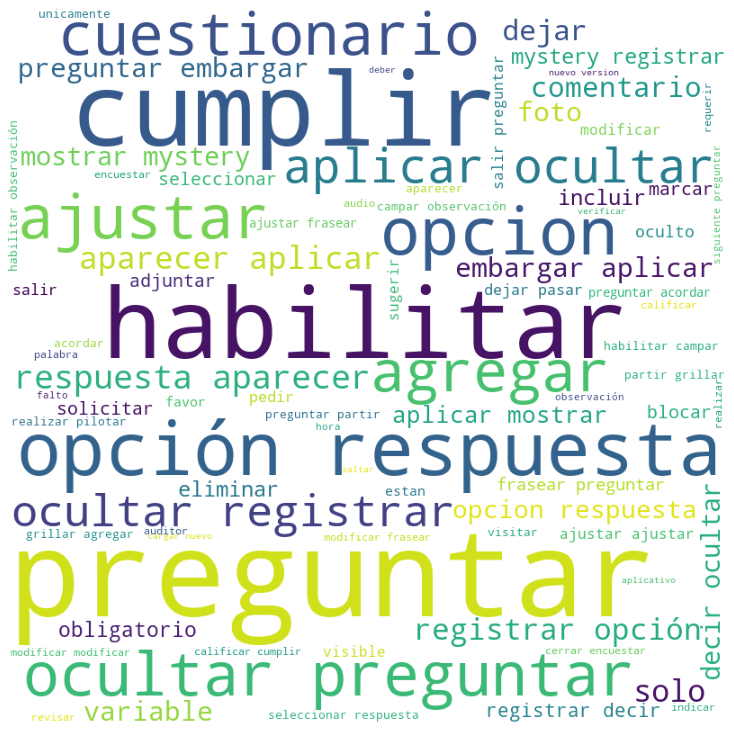

In [14]:
str_words = ' '.join(words) 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(str_words)
                    
plt.figure(figsize = (10,10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

### Corpus and TFIDF transformation

In [15]:
texts = data_lemmatized
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

tfidf = gensim.models.TfidfModel(corpus, smartirs='npu')
corpus_tfidf = tfidf[corpus]

### LDA

In [16]:
def models_computation(corpus, limit, start=2, step=3):
    
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = delayed(gensim.models.LdaMulticore)(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=10, workers=8)
        model_list.append(model)
        
    return model_list 

def coherence_perplexity_values_computation(model_list, dictionary, texts):
    
    coherence_values = []
    perplexity_values = []
    
    for model in model_list:
        coherencemodel = delayed(CoherenceModel)(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = delayed(model.log_perplexity)(corpus)
        perplexity_values.append(perplexity)
    
    return coherence_values, perplexity_values

In [17]:
%%time
limit=50; step=2;
result = models_computation(corpus=corpus_tfidf, limit=limit, step=step)
model_list = compute(*result)
result = coherence_perplexity_values_computation(model_list=model_list, dictionary=id2word, texts=data_lemmatized)
coherence_values, perplexity_values = compute(*result)

Wall time: 4min 11s


**Coherence**

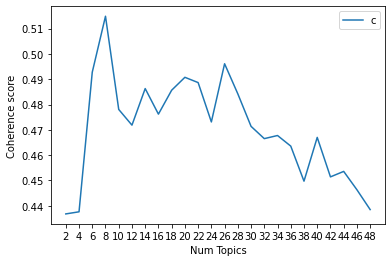

In [18]:
x = [ str(i) for i in range(2, limit, step)]
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 2  is having Coherence Value of 0.4368
Num Topics = 4  is having Coherence Value of 0.4376
Num Topics = 6  is having Coherence Value of 0.4928
Num Topics = 8  is having Coherence Value of 0.5149
Num Topics = 10  is having Coherence Value of 0.4781
Num Topics = 12  is having Coherence Value of 0.4718
Num Topics = 14  is having Coherence Value of 0.4863
Num Topics = 16  is having Coherence Value of 0.4762
Num Topics = 18  is having Coherence Value of 0.4856
Num Topics = 20  is having Coherence Value of 0.4907
Num Topics = 22  is having Coherence Value of 0.4887
Num Topics = 24  is having Coherence Value of 0.4731
Num Topics = 26  is having Coherence Value of 0.4961
Num Topics = 28  is having Coherence Value of 0.4842
Num Topics = 30  is having Coherence Value of 0.4714
Num Topics = 32  is having Coherence Value of 0.4665
Num Topics = 34  is having Coherence Value of 0.4678
Num Topics = 36  is having Coherence Value of 0.4636
Num Topics = 38  is having Coherence Value of 0.44

**Perplexity**

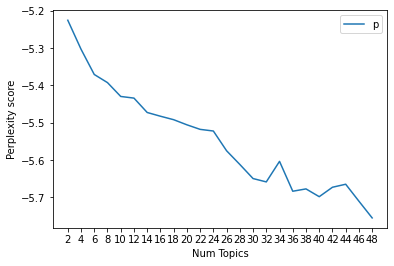

In [20]:
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [21]:
for m, cv in zip(x, perplexity_values):
    print("Num Topics =", m, " is having Perplexity Value of", round(cv, 4))

Num Topics = 2  is having Perplexity Value of -5.2258
Num Topics = 4  is having Perplexity Value of -5.3033
Num Topics = 6  is having Perplexity Value of -5.3709
Num Topics = 8  is having Perplexity Value of -5.3927
Num Topics = 10  is having Perplexity Value of -5.4297
Num Topics = 12  is having Perplexity Value of -5.4342
Num Topics = 14  is having Perplexity Value of -5.4726
Num Topics = 16  is having Perplexity Value of -5.4826
Num Topics = 18  is having Perplexity Value of -5.4919
Num Topics = 20  is having Perplexity Value of -5.5056
Num Topics = 22  is having Perplexity Value of -5.5178
Num Topics = 24  is having Perplexity Value of -5.5222
Num Topics = 26  is having Perplexity Value of -5.5751
Num Topics = 28  is having Perplexity Value of -5.6117
Num Topics = 30  is having Perplexity Value of -5.6494
Num Topics = 32  is having Perplexity Value of -5.6584
Num Topics = 34  is having Perplexity Value of -5.6034
Num Topics = 36  is having Perplexity Value of -5.6833
Num Topics = 3

**Optimal model**

In [22]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.066*"habilitar" + 0.039*"seleccionar" + 0.037*"opcion" + '
  '0.033*"observación" + 0.031*"campar" + 0.031*"cumplir" + 0.027*"variable" + '
  '0.024*"unicamente" + 0.022*"respuesta" + 0.022*"solo"'),
 (1,
  '0.072*"cumplir" + 0.042*"eliminar" + 0.039*"calificar" + 0.038*"marcar" + '
  '0.029*"realizar" + 0.027*"preguntar" + 0.024*"pilotar" + 0.024*"automatica" '
  '+ 0.023*"revisar" + 0.022*"obligatorio"'),
 (2,
  '0.095*"ajustar" + 0.053*"agregar" + 0.045*"saltar" + 0.042*"frasear" + '
  '0.035*"salir" + 0.033*"blocar" + 0.025*"falto" + 0.021*"respuesta" + '
  '0.017*"opcion" + 0.017*"indicacion"'),
 (3,
  '0.053*"cuestionario" + 0.036*"auditor" + 0.035*"ajustar" + 0.030*"sugerir" '
  '+ 0.022*"versus" + 0.020*"completar" + 0.020*"corresponder" + '
  '0.019*"campar" + 0.019*"habilitar" + 0.017*"modificar"'),
 (4,
  '0.062*"incluir" + 0.055*"dejar" + 0.035*"pasar" + 0.034*"fecho" + '
  '0.030*"permitir" + 0.030*"solicitar" + 0.026*"encuestar" + 0.023*"actual" + '
  '0.023*"se

**Saving files**

In [23]:
def topics(df):
    
    sent_topics_df = []
    
    for i, row in df:
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = optimal_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.append(dict(Dominant_Topic = int(topic_num), 
                                                            Perc_Contribution = round(prop_topic,4),
                                                            Topic_Keywords = topic_keywords))
            else:
                break
    
    return sent_topics_df

In [24]:
%%time
row_bd = bd.from_sequence(enumerate(optimal_model[corpus_tfidf]), npartitions = 10)
sent_topics_df = row_bd.map_partitions(topics)
sent_topics_df = sent_topics_df.to_dataframe()
sent_topics_df.head()

Wall time: 2.12 s


,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,6,0.7383,"ocultar, registrar, aplicar, aparecer, opción,..."
1,3,0.7606,"cuestionario, auditor, ajustar, sugerir, versu..."
2,7,0.8937,"nuevo, ingresar, cargar, version, estan, cajon..."
3,5,0.7871,"modificar, foto, frasear, variable, referencia..."
4,2,0.5370,"ajustar, agregar, saltar, frasear, salir, bloc..."


In [26]:
topics_df = sent_topics_df.compute()
topics_df['ID'] = list(data_lemmatized.index.values)
topics_df['Dominant_Topic'] = topics_df['Dominant_Topic'] + 1 

os.chdir('../SALIDAS')
topics_df.to_excel(project_name + col_name + '_' + filtro + '_LDA' + '.xlsx',index = False)

**Graphic representation**

In [27]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus_tfidf, id2word)
vis

C:\Users\David.Solano\Anaconda3\envs\David\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003747  0.156843       1        1  16.682966
6     -0.328937 -0.032480       2        1  15.935651
4      0.086743  0.017559       3        1  13.365511
2     -0.035231 -0.190948       4        1  11.885559
5      0.076550 -0.070820       5        1  11.849495
1     -0.012474  0.202248       6        1  11.210269
7      0.130668 -0.074159       7        1  10.392318
3      0.086429 -0.008242       8        1   8.678232, topic_info=           Term       Freq      Total Category  logprob  loglift
12      ajustar  51.000000  51.000000  Default  30.0000  30.0000
10    modificar  39.000000  39.000000  Default  29.0000  29.0000
30      ocultar  43.000000  43.000000  Default  28.0000  28.0000
121   registrar  44.000000  44.000000  Default  27.0000  27.0000
13      incluir  34.000000  34.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
80   comentario   3.270375  25.886645   Topic8  -4.4231   0.3755
176     acordar   3.104254  23.734221   Topic8  -4.4752   0.4102
118       rango   2.675796  10.143577   Topic8  -4.6237   1.1118
35      frasear   3.191502  29.844603   Topic8  -4.4475   0.2088
4     preguntar   3.253228  47.907776   Topic8  -4.4283  -0.2453

[425 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
295       6  0.871403           1
176       1  0.084267     acordar
176       2  0.631999     acordar
176       6  0.126400     acordar
176       8  0.126400     acordar
...     ...       ...         ...
232       3  0.079130     visitar
232       4  0.079130     visitar
84        2  0.344031  visualizar
84        6  0.344031  visualizar
84        7  0.258023  visualizar

[584 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 5, 3, 6, 2, 8, 4])

In [42]:
pyLDAvis.save_html(vis, project_name + col_name + '_LDA' + '.html')